In [92]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import highway_env
import matplotlib.pyplot as plt
import torch
import numpy as np

config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 40,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order": "sorted"
    },
    "action": {                      
        "type": "ContinuousAction",
        "longitudinal": True,
        "lateral": True,
       
        "steering_range": [-0.2, 0.2],  
        
        "speed_range": [15, 40],
        
        "right_lane_reward":0.2,
        "high_speed_reward":1.2,
    },
    "simulation_frequency": 15,
    "policy_frequency": 10,     
    "duration": 40, 
    "offroad_terminal": True,
    "lanes_count": 4, 
}

env = gym.make('highway-fast-v0', config=config, render_mode='rgb_array')
print(env.unwrapped.config)
obs, info = env.reset()
print(obs.shape)


{'observation': {'type': 'Kinematics', 'vehicles_count': 40, 'features': ['presence', 'x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'], 'features_range': {'x': [-100, 100], 'y': [-100, 100], 'vx': [-20, 20], 'vy': [-20, 20]}, 'absolute': False, 'order': 'sorted'}, 'action': {'type': 'ContinuousAction', 'longitudinal': True, 'lateral': True, 'steering_range': [-0.2, 0.2], 'speed_range': [15, 40], 'right_lane_reward': 0.2, 'high_speed_reward': 1.2}, 'simulation_frequency': 15, 'policy_frequency': 10, 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle', 'screen_width': 600, 'screen_height': 150, 'centering_position': [0.3, 0.5], 'scaling': 5.5, 'show_trajectories': False, 'render_agent': True, 'offscreen_rendering': False, 'manual_control': False, 'real_time_rendering': False, 'lanes_count': 4, 'vehicles_count': 20, 'controlled_vehicles': 1, 'initial_lane_id': None, 'duration': 40, 'ego_spacing': 1.5, 'vehicles_density': 1, 'collision_reward': -1, 'right_lane_reward': 0.1, 'high_speed

In [93]:
from TD3 import TD3

# Create a dummy agent
agent = TD3(env)

# Create a fake input batch: 32 images of size 4x128x64

# Fake flattened state
fake_state = torch.randn(32, agent.stateDim).to(agent.actor.f1.weight.device)

# Fake continuous action
fake_action = torch.randn(32, agent.actionDim).to(fake_state.device)

# Test Actor
print("Testing Actor...")
action = agent.actor(fake_state)
print("Actor output shape:", action.shape)  # (32, actionDim)

# Test Critic
print("Testing Critic...")
q1, q2 = agent.critic(fake_state, fake_action)
print("Critic outputs:", q1.shape, q2.shape)  # (32, 1)

Testing Actor...
Actor output shape: torch.Size([32, 2])
Testing Critic...
Critic outputs: torch.Size([32, 1]) torch.Size([32, 1])


In [86]:
import numpy as np
import matplotlib.pyplot as plt

modelName = "TD3"

def trainTD3(env, agent, totalEpisodes = 4000, maxSteps = 1000, randomSteps = 5000, evaluationFreq = 500, saveFreq = 2000):

    episodeRewards = []
    discountedRewards = []
    episodeLengths = []
    evaluationReturns = []

    timestep = 0

    agent.save(f"models/{modelName}_ep0")

    for episode in range(1, totalEpisodes + 1):

        obs, _ = env.reset()
        state = obs.flatten()

        episodeReward = 0.0
        discountedEpisodeReward = 0.0
        gammaPower = 1.0

        for step in range(maxSteps):
            timestep += 1

            if timestep < randomSteps:
                action = env.action_space.sample()
            else:
                action = agent.selectAction(state, explore = True)

            next_obs, reward, done, truncated, _ = env.step(action)
            next_state = next_obs.flatten()
            
            agent.learn(state, action, reward, (done or truncated, next_state))

            episodeReward += reward
            discountedEpisodeReward += gammaPower * reward
            gammaPower *= agent.gamma

            state = next_state

            if done or truncated:
                break

        episodeRewards.append(episodeReward)
        discountedRewards.append(discountedEpisodeReward)
        episodeLengths.append(step + 1)

        if episode % evaluationFreq == 0:
            evaluationReturn = evaluateTD3(agent, env)
            evaluationReturns.append((episode, evaluationReturn))

            print(
                f"Episode {episode:4d} | "
                f"Return: {episodeReward:7.2f} | "
                f"Discounted: {discountedEpisodeReward:7.2f} | "
                f"Eval: {evaluationReturn:7.2f}"
            )

        if episode % saveFreq == 0:
            agent.save(f"models/{modelName}_ep{episode}")

    return {
        "episodeRewards": episodeRewards,
        "discountedRewards": discountedRewards,
        "episodeLengths": episodeLengths,
        "evaluationReturns": evaluationReturns
    }


In [85]:
def evaluateTD3(agent, env, numEpisodes = 10):
    returns = []

    for _ in range(numEpisodes):
        state, _ = env.reset()
        done = False
        truncated = False
        episodeReturn = 0

        while not (done or truncated):
            action = agent.selectAction(state, explore = False)
            state, reward, done, truncated, _ = env.step(action)
            episodeReturn += reward

        returns.append(episodeReturn)

    return np.mean(returns)


In [101]:
def plotResults(results, savePath="figures/td3_results.png"):
    rewards = results["episodeRewards"]
    discount = results["discountedRewards"]
    episodeLengths = results["episodeLengths"]
    evaluationHistory = results["evaluationReturns"]
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))

    axes[0, 0].plot(rewards)
    axes[0, 0].set_title("TD3 Episodic Reward")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Reward")
    

    axes[0, 1].plot(discount)
    axes[0, 1].set_title("TD3 Episodic Discounted Rewards")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Discounted Reward")
    
    
    # Plot 2: Episode length
    axes[1, 0].plot(episodeLengths)
    axes[1, 0].set_title("Episode Length")
    axes[1, 0].set_xlabel("Episode")
    axes[1, 0].set_ylabel("Steps")


    episode = [item[0] for item in evaluationHistory]
    evaluationReturn = [item[1] for item in evaluationHistory]
    axes[1, 1].plot(episode, evaluationReturn, marker="o")
    axes[1, 1].set_title("Evaluation Return")
    axes[1, 1].set_xlabel("Episode")
    axes[1, 1].set_ylabel("Return")
    
    
    alpha = 0.05
    smoothedValues = []
    value = rewards[0]
    for r in rewards:
        value = alpha * r + (1 - alpha) * value
        smoothedValues.append(value)
        
        
    axes[2, 0].plot(smoothedValues)
    axes[2, 0].set_title("Smoothed Values")
    axes[2, 0].set_xlabel("Episode")
    axes[2, 0].set_ylabel("Steps")    
    
    axes[2, 1].axis("off")
        
    plt.tight_layout()
    plt.savefig(savePath)
    plt.show()
    


In [94]:
results = trainTD3(env = env, agent = agent, totalEpisodes = 6000, maxSteps = 1000, randomSteps = 5000, evaluationFreq = 500, saveFreq = 2000)


Episode  500 | Return:   31.97 | Discounted:   27.12 | Eval:  186.90
Episode 1000 | Return:  313.39 | Discounted:   75.23 | Eval:  283.52
Episode 1500 | Return:  323.04 | Discounted:   78.79 | Eval:  264.25
Episode 2000 | Return:  335.24 | Discounted:   80.38 | Eval:  246.52
Episode 2500 | Return:  304.08 | Discounted:   78.27 | Eval:  260.39
Episode 3000 | Return:  313.57 | Discounted:   75.71 | Eval:  287.01
Episode 3500 | Return:  339.01 | Discounted:   80.32 | Eval:  299.09
Episode 4000 | Return:  193.89 | Discounted:   76.08 | Eval:  267.14
Episode 4500 | Return:  299.97 | Discounted:   74.39 | Eval:  296.34
Episode 5000 | Return:  336.24 | Discounted:   87.23 | Eval:  295.69
Episode 5500 | Return:  348.10 | Discounted:   88.71 | Eval:  244.53
Episode 6000 | Return:  349.24 | Discounted:   80.14 | Eval:  323.80


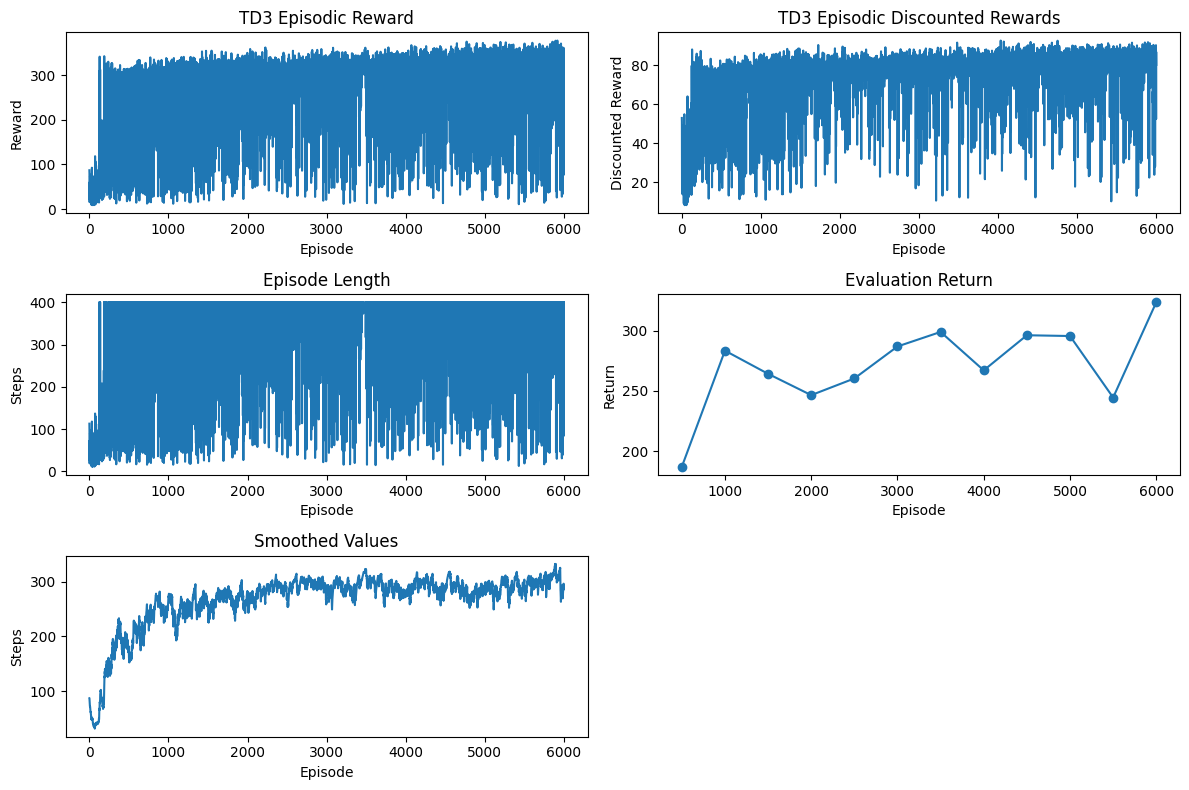

In [102]:
plotResults(results)


In [103]:
def recordTD3Videos(envId, envConfig, agent, checkpointPrefix, videoDirectory, numEpisodes = 3, prefix="TD3Eval"):
    
    agent.load(checkpointPrefix)
    env = gym.make(envId, config = envConfig, render_mode="rgb_array")
    env = RecordVideo(env, video_folder = videoDirectory, episode_trigger=lambda e: True, name_prefix = prefix)

    for ep in range(numEpisodes):
        obs, info = env.reset()
        done = truncated = False
        episodeReward = 0.0

        while not (done or truncated):
            action = agent.selectAction(obs.flatten(), explore=False)
            obs, reward, done, truncated, info = env.step(action)
            episodeReward += reward

        print(f"Episode {ep+1}/{numEpisodes} | Episode Reward: {episodeReward:.2f}")

    env.close()


In [104]:
checkpoints = [
    ("models/TD3_ep0",    "videos/TD3_ep0"),
    ("models/TD3_ep2000", "videos/TD3_ep2000"),
    ("models/TD3_ep4000", "videos/TD3_ep4000"),
    ("models/TD3_ep6000", "videos/TD3_ep6000")
]

for checkPrefix, videoDir in checkpoints:
    recordTD3Videos(envId = "highway-fast-v0", envConfig = config, agent = agent, checkpointPrefix = checkPrefix, videoDirectory = videoDir, numEpisodes = 3, prefix = os.path.basename(videoDir))


C:\Users\finna\AppData\Roaming\Python\Python313\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\finna\ReinforcementLearning\algorithms\TD3\videos\TD3_ep0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1/3 | Episode Reward: 41.78
Episode 2/3 | Episode Reward: 81.86
Episode 3/3 | Episode Reward: 41.78


C:\Users\finna\AppData\Roaming\Python\Python313\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\finna\ReinforcementLearning\algorithms\TD3\videos\TD3_ep2000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1/3 | Episode Reward: 167.22
Episode 2/3 | Episode Reward: 217.25
Episode 3/3 | Episode Reward: 307.66


C:\Users\finna\AppData\Roaming\Python\Python313\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\finna\ReinforcementLearning\algorithms\TD3\videos\TD3_ep4000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1/3 | Episode Reward: 323.59
Episode 2/3 | Episode Reward: 336.03
Episode 3/3 | Episode Reward: 321.79


C:\Users\finna\AppData\Roaming\Python\Python313\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\finna\ReinforcementLearning\algorithms\TD3\videos\TD3_ep6000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1/3 | Episode Reward: 363.01
Episode 2/3 | Episode Reward: 312.23
Episode 3/3 | Episode Reward: 311.21
